Credit/Resources:
* [Understanding the FFT Algorithm](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)
* [FFTW: The 1d Discrete Fourier Transform (DFT)](https://www.fftw.org/fftw3_doc/The-1d-Discrete-Fourier-Transform-_0028DFT_0029.html)
* [FFTW: Multi-dimensional Transforms](https://www.fftw.org/fftw3_doc/Multi_002ddimensional-Transforms.html)

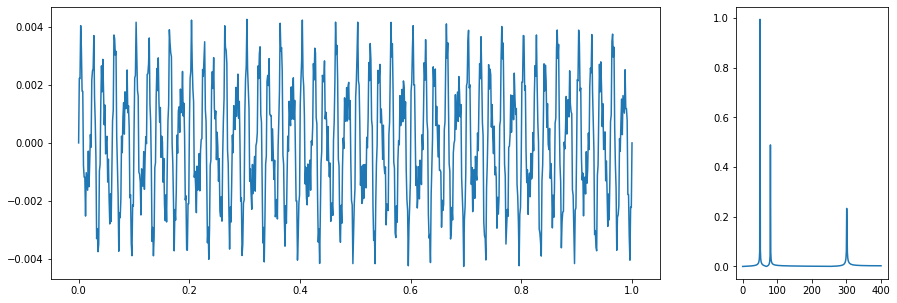

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Number of samplepoints
N = 800
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.3*np.sin(300.0 * 2.0*np.pi*x)
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [4, 1]})
ax1.plot(x, 2.0/N * y)
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

The discrete Fourier transform (DFT) computes the following.

$$Y_k = \sum_{j=0}^{n-1}{X_j}e^{-2\pi j k\sqrt{-1}/n}$$

Here is the näive version. What is the order? $\mathcal{O}(n)$? $\mathcal{O}(n\log{}n)$? $\mathcal{O}(n^2)$?

In [2]:
import numpy as np
def DFT(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [3]:
x = np.random.random(1024)
np.allclose(DFT(x), np.fft.fft(x))

True

In [4]:
%timeit DFT(x)
%timeit np.fft.fft(x)

27 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.66 µs ± 467 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [6]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

True

In [7]:
%timeit DFT(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

24.5 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.46 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.83 µs ± 294 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
def FFT2D(x):
    """Compute the discrete Fourier Transform of the 2D array x"""
    y=np.empty(x.shape,dtype=complex)
    for i in range(x.shape[0]):
        y[i,] = np.fft.fft(x[i,])
    for i in range(y.shape[1]):
        y[:,i] = np.fft.fft(y[:,i])
    return y

In [9]:
x = np.random.random((32,32))
np.allclose(FFT2D(x), np.fft.fft2(x))

True

In [10]:
def FFT3D(x):
    """Compute the discrete Fourier Transform of the 3D array x"""
    y=np.empty(x.shape,dtype=complex)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            y[i,j,] = np.fft.fft(x[i,j,])
    for i in range(y.shape[0]):
        for k in range(y.shape[2]):
            y[i,:,k] = np.fft.fft(y[i,:,k])
    for j in range(y.shape[1]):
        for k in range(y.shape[2]):
            y[:,j,k] = np.fft.fft(y[:,j,k])
    return y

In [11]:
x = np.random.random((32,32,32))
np.allclose(FFT3D(x), np.fft.fftn(x))

True

# Hermitian Symmetry
In the case of a real-input DFT (real to complex), it can be shown that the output array will possess the "Hermitian" symmetry $Y_k = Y^{*}_{n-k}$ where we take Y to be periodic so that $Y_n = Y_0$. The "Hermitian" symmetry also implies that $Y_0$ and $Y_{n/2}$ are purely real. This means that half of the "complex" values are redundant. The FFTW package uses this trick to reduce the memory footprint and number of calculations by only storing the non-redundant values.

This should make some intuitive sense based on the amount of "information".

$n\times \mathrm{sizeof(float)} = 1024 \times 4 = 4096$ bytes

$(n/2-1) \times \mathrm{sizeof(complex)} + 2 \times \mathrm{sizeof(float)} = 511 \times 8 + 2 \times 4 = 4096$ bytes

In [14]:
n = 1024
x = np.random.random(n)
y = np.fft.fft(x)
print(y[1:4])
print(y[n-1:n-4:-1])
print(y[0])
print(y[n//2])
np.allclose(y[1:n//2],np.conjugate(y[n-1:n//2:-1]))

[-3.14659414-6.59318687j  0.3700441 +8.5775523j  -5.01507134+6.05524431j]
[-3.14659414+6.59318687j  0.3700441 -8.5775523j  -5.01507134-6.05524431j]
(510.99223508596225+0j)
(18.185872200899382+0j)


True

# Density Contrast $\delta$
Last week we learned how to assign mass of "particles" onto a grid to give us the density in each region. The power spectrum is related to "density contrast" which we call $\delta$. The quantity $\delta$ is defined as:

$$\delta(\boldsymbol{r})\equiv {\rho(\boldsymbol{r}) - {\bar \rho} \over {\bar \rho}}\equiv {\rho(\boldsymbol{r}) \over {\bar \rho}} - 1$$

The quantity $\rho(\boldsymbol{r})$ is the density in each cell while the quantity ${\bar \rho}$ is the mean density.